# Forest Type Cover Prediction from Kaggle

Dataset and description can be found on: ht<span>tps://www</span>.kaggle.com/c/forest-cover-type-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import brewer2mpl
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

%matplotlib inline

Optimization of train and test dataset

train.info()

train = pd.read_csv('train.csv')

for column in train.columns:
    print( column, train[column].max() )


Running code above (with original csv file) it becomes clear that Slope, Soil, Cover_Type and Wilderness columns may be optimized by change of their type to int8, while the rest of columns may have type int16. All columns are int. It may be performed by the code below. The last line saves the file to HDF5 format (.h5 extension).

for column in train.columns:
    if 'Soil' in column or 'Wilderness' in column: 
        train[ column ] = train[ column ].astype('int8')
        
train[ 'Slope' ] = train[ 'Slope' ].astype('int8')

train[ 'Cover_Type' ] = train[ 'Cover_Type' ].astype('int8')
cols_int16 = ['Id', 'Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', \
              'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', \
              'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
             ]

for col in cols_int16:
    train[ col ] = train[ col ].astype('int16')
    
train.to_hdf('train.h5', 'data')

In [2]:
#load data from optimized file
train = pd.read_hdf('train.h5')

## Overall Information

In [3]:
train.head(7)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5
5,6,2579,132,6,300,-15,67,230,237,140,...,0,0,0,0,0,0,0,0,0,2
6,7,2606,45,7,270,5,633,222,225,138,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [5]:
def check_missing():
    for column in train.columns:
        missing = column, train[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

## Pandas Profiling (optional)

In [6]:
#import pandas_profiling
#pandas_profiling.ProfileReport(train)

## Correlation Heatmap

It is definitely impractical to produce a correlation heatmap with over 40 columns. Therefore I make a copy of train dataset (df) with only significant features. Durin Feature Engineering process it is important to update df with new/updated features.

In [7]:
df = train[['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points','Cover_Type']].copy()

df Feature Engineering in two examples. The point is to compare feature before and afert Engineering and decide which may have strongest correlation with the target variable.

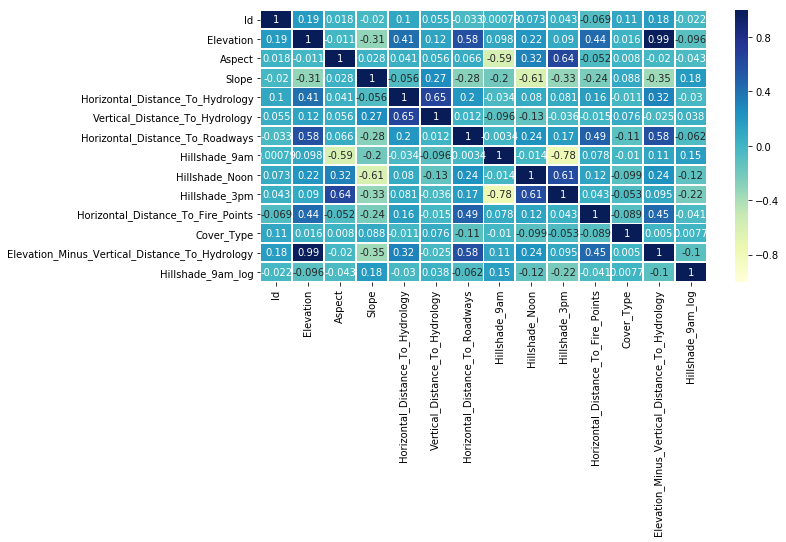

In [8]:
df['Elevation_Minus_Vertical_Distance_To_Hydrology'] = df['Elevation']-df['Vertical_Distance_To_Hydrology']
df['Hillshade_9am_log'] = np.log(df['Hillshade_9am'] + 150).astype(int)

plt.rcParams['figure.figsize']=(10,5)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

## Plots/visualizations/histograms

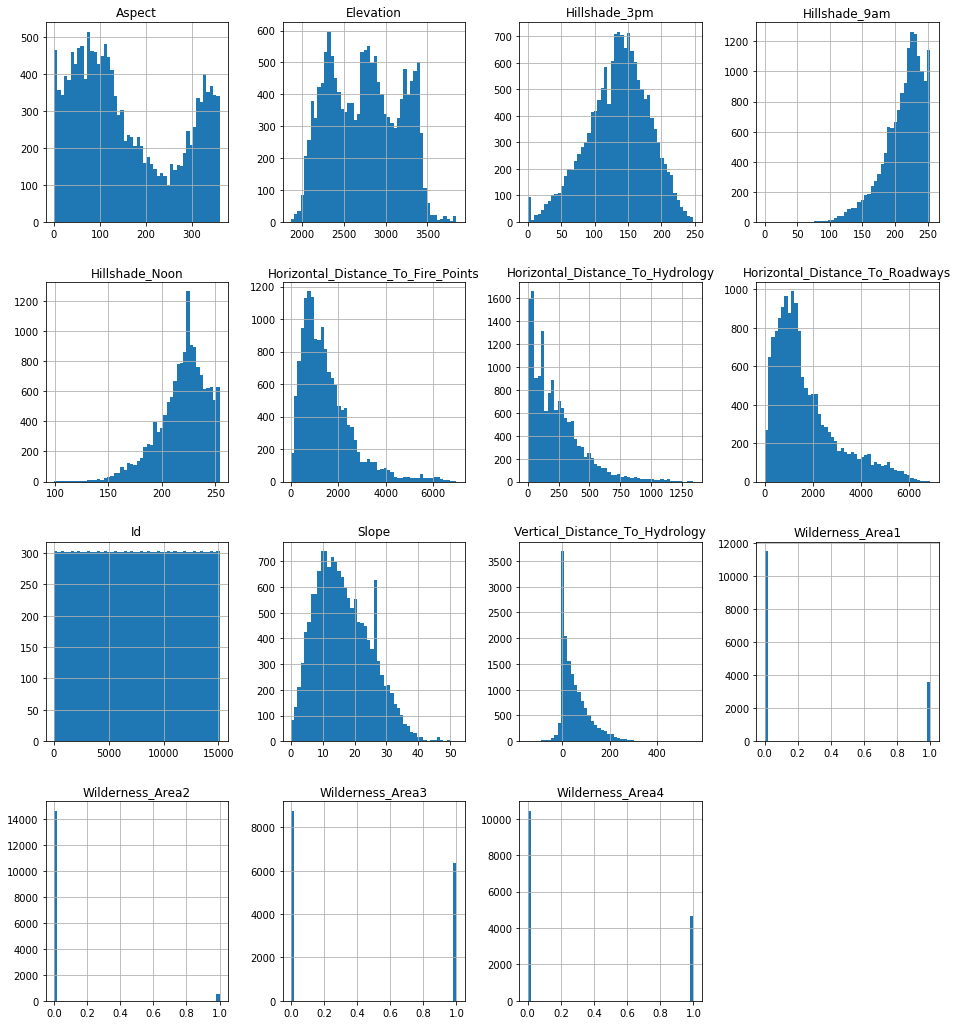

In [9]:
train.iloc[:,:15].hist(figsize=(16,18),bins=50);

For these columns which I consider logarithmic distribution I apply following code to check does it looks more Gaussian like. This helps me in Feature Engineering

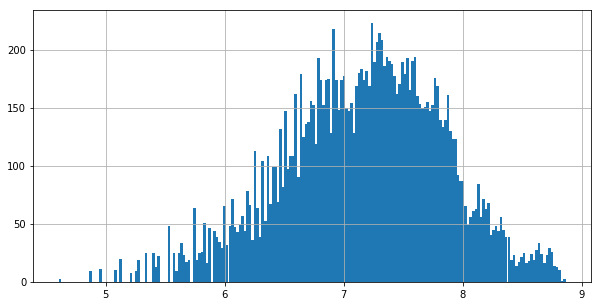

In [10]:
# to examine other column just put it's name into the quotation marks

np.log(train[ 'Horizontal_Distance_To_Fire_Points' ]+ 100).hist(bins = 200)

In [11]:
def plot_elevation_vert_distance(col_1, col_2):
    colors = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors

    fig = plt.figure(figsize=(16,8))

    plt.xlabel(col_1.name)
    plt.ylabel(col_2.name)
    plt.scatter(col_1, col_2,s=150, c=colors);
    

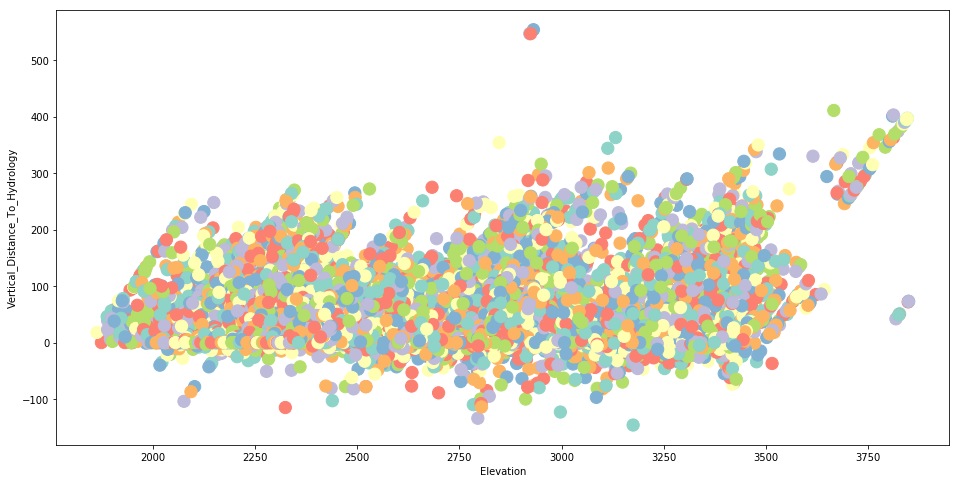

In [12]:
plot_elevation_vert_distance(train.Elevation, train.Vertical_Distance_To_Hydrology)

## Feature Engineering

In [13]:
train['Elevation_Minus_Vertical_Distance_To_Hydrology'] = train['Elevation']-train['Vertical_Distance_To_Hydrology']
train['Hillshade_9am_log'] = np.log(train['Hillshade_9am'] + 150).astype(int)
train['Hillshade_Noon_log'] = np.log(train['Hillshade_Noon'] + 100).astype(int)
train['Hillshade_3pm_log'] = np.log(train['Hillshade_3pm'] + 100).astype(int)
train['Distance_to_hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5
train['Distance_to_hydrology_log'] = np.log(train['Hillshade_3pm']+ 100).astype(int)
train['Vertical_Distance_To_Hydrology_binary'] = train['Vertical_Distance_To_Hydrology'].map(lambda x: int(x>=0))
train['Horizontal_Distance_To_Fire_Points_log' ] = np.log(train[ 'Horizontal_Distance_To_Fire_Points' ]+ 100)
train['Horizontal_Distance_To_Roadways_log'] = np.log(train[ 'Horizontal_Distance_To_Roadways' ]+100)
train['Distance_To_Hydrology_binary'] = train['Distance_to_hydrology'].map(lambda x: int(x==0))
train['Hillshade_3pm_binary'] = train['Hillshade_3pm'].map(lambda x: int(x==0))

## Model Building

In [14]:
def train_predict(X_train,X_test,y_train,y_test,model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [15]:
features = ['Elevation','Slope','Aspect','Elevation_Minus_Vertical_Distance_To_Hydrology','Hillshade_9am_log'\
            ,'Distance_to_hydrology_log','Wilderness_Area1'\
            , 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',\
            'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8','Soil_Type9', 'Soil_Type10', 'Soil_Type11'\
            , 'Soil_Type12','Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 'Soil_Type18', \
            'Soil_Type19', 'Soil_Type20','Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',\
            'Soil_Type26', 'Soil_Type27', 'Soil_Type28','Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',\
            'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36','Soil_Type37', 'Soil_Type38', 'Soil_Type39',\
            'Soil_Type40','Vertical_Distance_To_Hydrology_binary','Horizontal_Distance_To_Fire_Points_log',\
            'Horizontal_Distance_To_Roadways_log','Distance_To_Hydrology_binary','Hillshade_3pm_binary']

y = train['Cover_Type']
X = train[features]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state = 2000)
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),xgb.XGBClassifier(),lgb.LGBMClassifier()]
for model in models:
    print(model)
    print(train_predict(X_train,X_test,y_train,y_test,model))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6619425548
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.792705971277
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=Fal

## Hyperopt for LGBMClassifier

In [16]:
def objective(space):
    
    params = {
        'max_depth':int(space['max_depth']),
        'learning_rate':space['learning_rate'],
        'num_leaves ':space['num_leaves '],
        'n_estimators':int(space['n_estimators']),
        'subsample_for_bin':int(space['subsample_for_bin']),
        'colsample_bytree':space['colsample_bytree'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda']
        
    }
    
    model = lgb.LGBMClassifier(**params, objective = 'multiclass')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = 1 - accuracy_score(y_pred,y_test)
    
    print('Score: {0}'.format(score))
    return {'loss':score,'status':STATUS_OK}

space = {
    'max_depth':hp.quniform('max_depth',0,25,1),
    'learning_rate':hp.uniform('learning_rate',0.1,1),
    'num_leaves ':hp.quniform('num_leaves ',2,31,1),
    'n_estimators':hp.quniform('n_estimators',30,1000,3),
    'subsample_for_bin':hp.quniform('subsample_for_bin',100,20000,100),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.)
}

trials = Trials()
best_params = fmin(fn = objective,
                  space = space,
                  algo=partial(tpe.suggest, n_startup_jobs = 10),
                  max_evals = 50,
                  trials = trials)

print('Best params: ', best_params)

Score: 0.1634542705971277
Score: 0.14739229024943312
Score: 0.15117157974300832
Score: 0.15022675736961455
Score: 0.1534391534391535
Score: 0.14795918367346939
Score: 0.1462585034013606
Score: 0.14399092970521543
Score: 0.24225245653817085
Score: 0.16421012849584282
Score: 0.15060468631897206
Score: 0.14040060468631899
Score: 0.13851095993953133
Score: 0.13983371126228272
Score: 0.1504157218442933
Score: 0.1394557823129252
Score: 0.14569160997732422
Score: 0.1369992441421013
Score: 0.13718820861678005
Score: 0.13964474678760397
Score: 0.1366213151927438
Score: 0.1390778533635676
Score: 0.13983371126228272
Score: 0.13794406651549507
Score: 0.14304610733182166
Score: 0.1415343915343915
Score: 0.14266817838246415
Score: 0.14096749811035525
Score: 0.13888888888888884
Score: 0.14058956916099774
Score: 0.1377551020408163
Score: 0.13832199546485258
Score: 0.1432350718065004
Score: 0.14342403628117917
Score: 0.14890400604686316
Score: 0.1483371126228269
Score: 0.141156462585034
Score: 0.146636

In [18]:
model = lgb.LGBMClassifier(colsample_bytree = 0.9829106775621018, learning_rate = 0.22822996408429214, max_depth = 20, n_estimators = 510, num_leaves = 21, subsample_for_bin = 12400, reg_alpha = 1.1528589583477689, reg_lambda = 0.9587527359236657)
print(train_predict(X_train,X_test,y_train,y_test,model))

0.860922146636


The LGBM Classifier model has been improved with hyperopt